# Constructpy Example Usecase

This notebook showcases some basic usage of the constructpy library

In [15]:
from constructpy import Constructability
import ifcopenshell
import ifcopenshell.geom
import k3d
import matplotlib.pyplot as plt
import numpy as np
import collections

Constructpy needs an IFC file loaded into a ifcopenshell.file object:

In [16]:
ifc_file = 'rstadvancedsampleproject_patched.ifc'
ifc = ifcopenshell.open(ifc_file)

Create a Constructability object passing optional weights (this might take a few seconds as it does all the calculations).
The Constructability object instanciates the Standardization, Simplicity and Accessibility objects and executes all constructability assessments methods available. It also takes optional weights used in the calculations. More information ond the existing methods in the [documentation](https://chrisjesuscj.github.io/constructpy/).

In [17]:
# Set weights for main constructability calculation
standadization_weight = 0.8
simplicity_weight = 1.0
accessibility_weight = 0.6

# Create a constructability object passing the ifc and weights
con = Constructability(ifc, standadization_weight, simplicity_weight, accessibility_weight)

The data created from the Constructability object can be accessed by its attributes, as shown below, where the data is being organized to feed a matplotlib chart:

In [18]:
# Data and Text Labels
data = {
    'Accessibility': [con.accessibility.location_score, con.accessibility.area_score],
    'Simplicity': [con.simplicity.pcast_score, con.simplicity.length_score, con.simplicity.basement_score],
    'Standardization': [con.standardization.floor2floor_height_score, con.standardization.structural_types_score],
    'Constructability': [con.accessibility_score, con.simplicity_score, con.standardization_score, con.constructability_score]
}

text_labels = {
    'Accessibility': ['Location', 'Built Area'],
    'Simplicity': ['Precast Elements', 'Length of Beams', 'Has Basement'],
    'Standardization': ['Floor to Floor Height', 'Structural Types'],
    'Constructability': ['Accessibility Score', 'Simplicity Score', 'Standardization Score', 'Constructability Score']
}

The script below creates a matplotlib chart breaking down all the constructability scores calculated for an easy overview:

Text(0.5, 1.0, 'Constructability Chart')

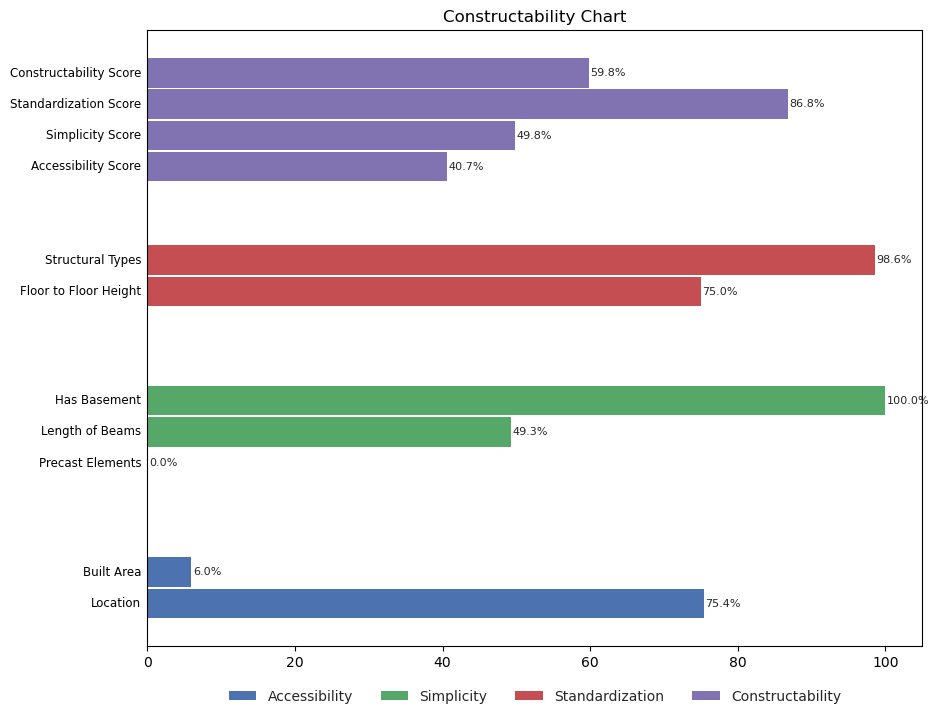

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
plt.style.use('seaborn-v0_8')

k, v = zip(*data.items())
max_n_bars = max(len(v) for v in data.values())
group_centers = np.cumsum([max_n_bars for _ in data.items()]) - (max_n_bars / 2)
bar_offset = (1 - 0.95) / 2
bars = collections.defaultdict(list)

colors = {g_name: [f"C{i}" for _ in values] for i, (g_name, values) in enumerate(data.items())}

for g_i, ((g_name, vals), g_center) in enumerate(zip(data.items(), group_centers)):
    n_bars = len(vals)
    group_radius = 0.8 * (n_bars - 0.95) * 0.5
    group_beg = g_center - group_radius
    for val_i, val in enumerate(vals):
        val = val*100
        bar = ax.barh(group_beg + (val_i + bar_offset) * 0.8,  
                     width=val, height=0.95 * 0.8,
                     color=colors[g_name][val_i])[0]
        bars[g_name].append(bar)

        y_pos = bar.get_y() + (bar.get_height() / 2.0)
        x_pos = val + 0.2
        barlbl = f'{val:.1f}%'
        ax.text(x_pos, y_pos, barlbl, ha="left", va="center", fontsize=8)

        if text_labels and g_name in text_labels and val_i < len(text_labels[g_name]):
            text_label = text_labels[g_name][val_i]
            text_x_pos = x_pos - val - 1
            ax.text(text_x_pos, y_pos, text_label, ha="right", va="center", fontsize=8.5, color='black', weight='normal')

ax.legend([bars[k][0] for k in k], k, loc='upper center', ncols=4, bbox_to_anchor=(0.5,-0.05), shadow=True)
ax.set_yticks([])
ax.set_yticklabels([])
ax.spines[['right','top', 'bottom']].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_title("Constructability Chart")


Aside from the scores, some other useful information can also be gathered from the objects, a few examples below:

In [20]:
# Getting information on site location
nearest_city = con.accessibility.location_city[0]
distance_city = con.accessibility.location_city[1]

print(f'The nearest city found is {nearest_city} at {distance_city:.2f} kilometers from the site.')

# Getting the beams that passed the length test
valid_beams = con.simplicity.valid_beams

# Getting the beams that didn't pass
invalid_beams = ifc.by_type("IfcBeam")
for beam in invalid_beams:
    if beam in valid_beams:
        invalid_beams.remove(beam)

print(f'The valid beams found are: {valid_beams}')
print(f'The invalid beams found are: {invalid_beams}')


The nearest city found is Mont-Tremblant at 24.64 kilometers from the site.
The valid beams found are: [#2697=IfcBeam('1WrzGm1SD2ev45B_OWQ39H',#18,'M_Concrete-Rectangular Beam:400 x 800mm:124565',$,'M_Concrete-Rectangular Beam:400 x 800mm',#2696,#2693,'124565',.BEAM.), #2858=IfcBeam('1WrzGm1SD2ev45B_OWQ39S',#18,'M_Concrete-Rectangular Beam:400 x 800mm:124568',$,'M_Concrete-Rectangular Beam:400 x 800mm',#2857,#2854,'124568',.BEAM.), #3034=IfcBeam('1WrzGm1SD2ev45B_OWQ39V',#18,'M_Concrete-Rectangular Beam:400 x 800mm:124571',$,'M_Concrete-Rectangular Beam:400 x 800mm',#3033,#3030,'124571',.BEAM.), #3387=IfcBeam('1WrzGm1SD2ev45B_OWQ39b',#18,'M_Concrete-Rectangular Beam:400 x 800mm:124577',$,'M_Concrete-Rectangular Beam:400 x 800mm',#3386,#3383,'124577',.BEAM.), #3714=IfcBeam('1WrzGm1SD2ev45B_OWQ39Y',#18,'M_Concrete-Rectangular Beam:400 x 800mm:124582',$,'M_Concrete-Rectangular Beam:400 x 800mm',#3713,#3710,'124582',.BEAM.), #3888=IfcBeam('1WrzGm1SD2ev45B_OWQ39j',#18,'M_Concrete-Rectangular

The valid and invalid beams gathered above can be used in visualizations like created whit script below, alowing to see in an 3D model the exact location of the beams:

In [21]:
settings = ifcopenshell.geom.settings()
settings.set(settings.USE_WORLD_COORDS, True)
plot = k3d.plot()

for product in ifc.by_type('IfcProduct'):
    if product.is_a('IfcOpeningElement') or product.is_a('IfcSpace'):
        continue
    if product.Representation:
        if product in invalid_beams:
            opacity = 1.0
            color = 0xdd2779
        else:
            opacity = 0.15
            color = 0xc0aec
        shape = ifcopenshell.geom.create_shape(settings, product)
        vertices = shape.geometry.verts
        faces = shape.geometry.faces
        plot += k3d.mesh(vertices, faces, opacity=opacity, color=color)

plot.mode = 'Change'
plot.camera_mode = 'orbit'
plot.display()


Output()